## NEURAL NETWORK TO PREDICT INCOME

In [318]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from copy import deepcopy
import torch.nn.functional as F
import seaborn as sns
import shap
import copy
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

In [319]:
pd.read_csv("filtered_data.csv")

,AGE,SEX,RACE,EDUC,UHRSWORK,PWSTATE2,INCWAGE,parent_income,parent_educ,OCC_CATEGORY
0,25,1,1,6,43,1,29497,72799.0,7,Office and Administrative Support OCC
1,28,1,8,6,40,1,21238,63714.0,6,"Installation, Maintenance, and Repair OCC"
2,26,2,1,10,43,1,42358,55543.0,6,"Education, Legal, Community Service, Arts, and..."
3,29,1,1,10,40,1,100290,158105.0,10,"Computer, Engineering, Science OCC"
4,28,1,2,7,48,1,47195,27137.0,6,"Production, Transportation, and Material Movin..."
...,...,...,...,...,...,...,...,...,...,...
118210,25,1,1,6,40,56,28100,54000.0,11,Service OCC
118211,26,1,1,7,55,56,40000,50000.0,8,"Installation, Maintenance, and Repair OCC"
118212,27,2,1,10,40,56,34000,72350.0,7,"Management, Buisness and Financial OCC"
118213,26,2,1,11,40,31,64000,44500.0,10,Healthcare Practitioners and Technical OCC


## Features for NN

    AGE: 
Age in years (has to be between 30 and 40)

    SEX:
Biological sex (1=Male, 2=Female)

    RACE:
Race codes (1=White, 2=Black, 3 = American Indian etc.)

    EDUC:
Education codes (e.g., 07=1 year of college, 08=2 years of college)

    UHRSWORK:
Usual hours worked per week (>35)
 
    OCC_CATEGORY:
Occupation code (e.g., 3650=Software developers)

    PWSTATE2:
Place of work: state

    INCTOT:
Total personal income (sum of all sources)

    INCWAGE:
Income from wage

    parent_income:
Average income of parents

    parent_educ:
Max_education(parent1, parent2)

In [320]:
def check_categorical_coverage(X_train, X_test, categorical_features):

    missing_categories = {}

    for feature in categorical_features:
        train_cats = set(X_train[feature].unique())
        test_cats = set(X_test[feature].unique())

        diff = test_cats - train_cats
        if len(diff) > 0:
            missing_categories[feature] = diff

    if missing_categories:
        for feature, cats in missing_categories.items():
            print(f"- {feature}: {len(cats)} missing categories ({list(cats)})")
        return False
    else:
        print("Data seems to be good")
        return True

def prep_data(filename, numerical_cols, embed_cols):
    data = pd.read_csv(filename)

    race_dummies = pd.get_dummies(data['RACE'], prefix='RACE')
    data = pd.concat([data.drop('RACE', axis=1), race_dummies], axis=1)

    sex_dummies = pd.get_dummies(data['SEX'], prefix='SEX')
    data = pd.concat([data.drop('SEX', axis=1), sex_dummies], axis=1)

    # Label encode OCC_CATEGORY and PWSTATE2
    label_encoders = {}
    for col in embed_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

    # Scale numerical features
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Split features and target
    y = data['INCWAGE'].values
    X = data.drop('INCWAGE', axis=1)

    return X, y, embed_cols, numerical_cols, label_encoders

In [321]:
def create_loader(X, y, embed_cols, numerical_cols, batch_size=64, val_size=0.1, test_size=0.1, random_seed=42):
    # Split the dataset
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_relative_size, random_state=random_seed)

    print(f"Train: {len(X_train)/len(X):.1%}, Val: {len(X_val)/len(X):.1%}, Test: {len(X_test)/len(X):.1%}")
    check_categorical_coverage(X_train, X_test, embed_cols)
    check_categorical_coverage(X_train, X_test, ["EDUC", "parent_educ"])

    def build_dataset(X_df, y_array):
        for col in embed_cols:
            X_df[col] = X_df[col].astype('int64')
        for col in numerical_cols:
            X_df[col] = X_df[col].astype('float32')

        cat_data = [torch.tensor(X_df[col].values, dtype=torch.long) for col in embed_cols]
        num_data = torch.tensor(X_df[numerical_cols].values, dtype=torch.float32)
        y_tensor = torch.tensor(y_array, dtype=torch.float32)

        return TensorDataset(*cat_data, num_data, y_tensor)

    return (
        DataLoader(build_dataset(X_train, y_train), batch_size=batch_size, shuffle=True),
        DataLoader(build_dataset(X_val, y_val), batch_size=batch_size, shuffle=False),
        DataLoader(build_dataset(X_test, y_test), batch_size=batch_size, shuffle=False),
        X_test, X_train
    )

In [322]:
#Model architecture

def get_embedding_dim(n_unique):
    return min(50, max(1, n_unique // 2))


class IncomePredictor(nn.Module):
    def __init__(self, cat_features, num_input_dim):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(n_unique, get_embedding_dim(n_unique))
            for name, n_unique in cat_features.items()
        })

        self.num_bn = nn.BatchNorm1d(num_input_dim)
        total_embed_dim = sum(embed.embedding_dim for embed in self.embeddings.values())
        total_input_dim = total_embed_dim + num_input_dim
        print(f"Total model input dimension: {total_input_dim}")

        self.net = nn.Sequential(
            nn.Linear(total_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1)
        )

    def forward(self, inputs):
        *cat_inputs, x_num = inputs
        x_embed = [self.embeddings[name](cat_input) for name, cat_input in zip(self.embeddings.keys(), cat_inputs)]
        x_embed = torch.cat(x_embed, dim=1)
        x_num = self.num_bn(x_num)
        x = torch.cat([x_embed, x_num], dim=1)
        return self.net(x).squeeze(1)

In [323]:
def train_model(cat_features, train_loader, val_loader, n_epochs=100, patience=5):

    num_input_dim = train_loader.dataset.tensors[-2].shape[1]
    model = IncomePredictor(cat_features, num_input_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.1)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for *cat_inputs, x_num, y in train_loader:
            optimizer.zero_grad()
            outputs = model([*cat_inputs, x_num])
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for *cat_inputs, x_num, y in val_loader:
                outputs = model([*cat_inputs, x_num])
                loss = criterion(outputs, y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return best_model



In [324]:
def eval_model(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_true = []

    with torch.no_grad():
        for *cat_inputs, x_num, y in test_loader:
            cat_inputs = [c.to(device) for c in cat_inputs]
            x_num = x_num.to(device)
            y = y.to(device)

            preds = model([*cat_inputs, x_num])
            all_preds.append(preds.cpu().numpy())
            all_true.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)

    mae = mean_absolute_error(all_true, all_preds)
    mse = mean_squared_error(all_true, all_preds)
    r2 = r2_score(all_true, all_preds)

    print(f"\nEvaluation Results:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    return mae, mse, r2



In [325]:
original_categorical_cols = ["SEX", "RACE", "OCC_CATEGORY", "PWSTATE2", "EDUC", "parent_educ"]
numerical_cols_base = ["AGE", "UHRSWORK", "parent_income"]
embed_cols = ['OCC_CATEGORY', 'PWSTATE2']

X, y, embed_cols, numerical_cols, label_encoders = prep_data("filtered_data.csv", numerical_cols_base, embed_cols)

numerical_cols = numerical_cols_base + ["EDUC", "parent_educ"] + \
                 [col for col in X.columns if col.startswith("RACE_")] + \
                 [col for col in X.columns if col.startswith("SEX_")]

cat_features = {col: X[col].nunique() for col in embed_cols}

train_loader, val_loader, test_loader, X_test, X_train = create_loader(X, y, embed_cols, numerical_cols)

model = train_model(cat_features, train_loader, val_loader)
eval_model(model, test_loader)


Train: 80.0%, Val: 10.0%, Test: 10.0%
Data seems to be good
Data seems to be good
Total model input dimension: 50
Epoch 1 - Train Loss: 2537527571.2260 - Val Loss: 2073940668.8865
Epoch 2 - Train Loss: 1488072293.3478 - Val Loss: 916433415.2649
Epoch 3 - Train Loss: 721651183.1123 - Val Loss: 510548924.8000
Epoch 4 - Train Loss: 502929119.0095 - Val Loss: 467064276.4973
Epoch 5 - Train Loss: 490346623.5020 - Val Loss: 466218634.2054
Epoch 6 - Train Loss: 489758768.0866 - Val Loss: 467079291.6757
Epoch 7 - Train Loss: 487055518.7118 - Val Loss: 465535091.3730
Epoch 8 - Train Loss: 488670846.0839 - Val Loss: 747435615.6541
Epoch 9 - Train Loss: 487838396.5900 - Val Loss: 13394698093.1459
Epoch 10 - Train Loss: 485705014.7009 - Val Loss: 1608657557488.8647
Epoch 11 - Train Loss: 484484827.9729 - Val Loss: 606799279893.0162
Epoch 12 - Train Loss: 483819560.4871 - Val Loss: 2196233989619.2864
Early stopping triggered.

Evaluation Results:
Mean Absolute Error (MAE): 14947.3643
Mean Squared E

(14947.3642578125, 481853856.0, 0.28845083713531494)

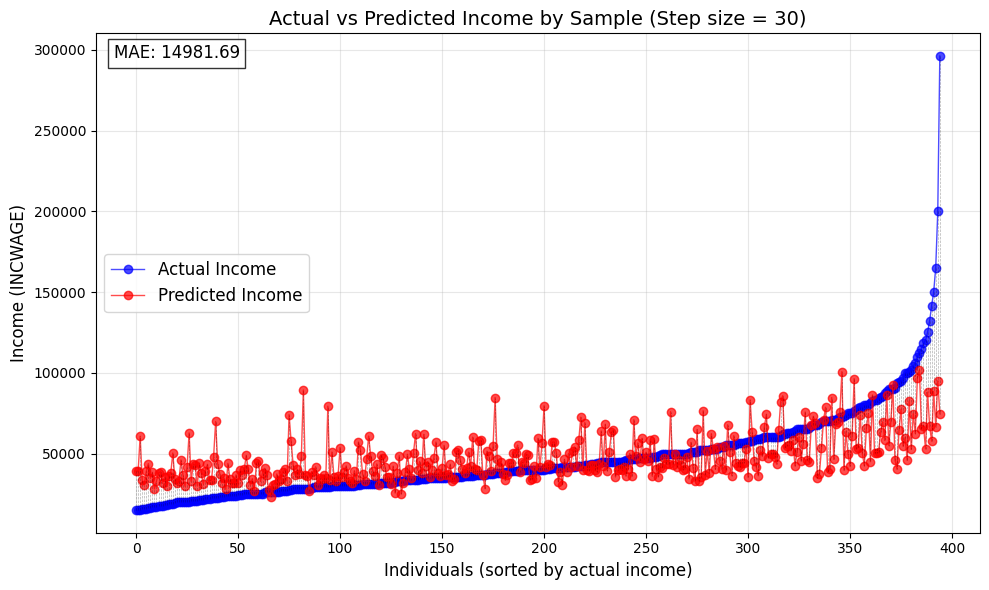

In [326]:
# Plot actual vs predicted
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for *cat_inputs, x_num, y in test_loader:
        preds = model([*cat_inputs, x_num])
        y_true.append(y.numpy())
        y_pred.append(preds.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)


sort_idx = np.argsort(y_true)
y_true_sorted = y_true[sort_idx]
y_pred_sorted = y_pred[sort_idx]

step_size = 30
sample_idx = range(0, len(y_true_sorted), step_size)

y_true_sampled = y_true_sorted[sample_idx]
y_pred_sampled = y_pred_sorted[sample_idx]

plt.figure(figsize=(10, 6))
plt.plot(y_true_sampled, 'o-', color='blue', label='Actual Income', markersize=6, linewidth=1, alpha=0.7)
plt.plot(y_pred_sampled, 'o-', color='red', label='Predicted Income', markersize=6, linewidth=1, alpha=0.7)

for i in range(len(y_true_sampled)):
    plt.plot([i, i], [y_true_sampled[i], y_pred_sampled[i]], 'k--', linewidth=0.5, alpha=0.3)
plt.xlabel('Individuals (sorted by actual income)', fontsize=12)
plt.ylabel('Income (INCWAGE)', fontsize=12)
plt.title(f'Actual vs Predicted Income by Sample (Step size = {step_size})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

mae = np.mean(np.abs(y_true_sampled - y_pred_sampled))
plt.text(0.02, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)
plt.tight_layout()
plt.show()

## Metrics and Analysis

In [327]:
def calculate_metrics(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'Median Absolute Error': median_absolute_error(y_true, y_pred),
        'Mean Absolute Percentage Error': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics

def income_specific_metrics(y_true, y_pred):
    # Percentage within $10K
    within_10k = np.mean(np.abs(y_true - y_pred) < 10000) * 100
    
    # Percentage within 20%
    within_20pct = np.mean(np.abs(y_true - y_pred) / y_true < 0.2) * 100
    
    return {
        '% within $10K': within_10k,
        '% within 20%': within_20pct,
        'Top 10% Accuracy': np.mean(np.sign(y_true - np.percentile(y_true, 90)) == 
                          np.sign(y_pred - np.percentile(y_true, 90)))
    }

def plot_performance(y_true, y_pred):
    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Income')
    plt.ylabel('Predicted Income')
    
    # Error distribution
    plt.subplot(1, 3, 2)
    errors = y_true - y_pred
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel('Prediction Error')
    
    # Percentile comparison
    plt.subplot(1, 3, 3)
    percentiles = np.linspace(0, 100, 20)
    actual_percentiles = np.percentile(y_true, percentiles)
    pred_percentiles = np.percentile(y_pred, percentiles)
    sns.lineplot(x=percentiles, y=actual_percentiles, label='Actual')
    sns.lineplot(x=percentiles, y=pred_percentiles, label='Predicted')
    plt.xlabel('Percentile')
    plt.ylabel('Income')
    
    plt.tight_layout()
    plt.show()
    
def statistical_validation(y_true, y_pred):
    # Normality of residuals
    shapiro_test = stats.shapiro(y_true - y_pred)
    
    # Bias test (mean error significantly different from 0)
    t_test = stats.ttest_1samp(y_true - y_pred, 0)
    
    return {
        'Residual Normality (Shapiro)': shapiro_test,
        'Bias Test (t-test)': t_test
    }

In [328]:
metrics = calculate_metrics(y_true, y_pred)
income_metrics = income_specific_metrics(y_true, y_pred)

print("Standard Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# print("\nIncome-Specific Metrics:")
# for k, v in income_metrics.items():
#     print(f"{k}: {v:.2f}%")

# # Visualizations
# plot_performance(y_true, y_pred)


# # Statistical tests
# stats_results = statistical_validation(y_true, y_pred)

Standard Metrics:
MAE: 14947.3643
RMSE: 21951.1698
R²: 0.2885
Median Absolute Error: 10972.2949
Mean Absolute Percentage Error: 37.0951



Metrics for Income < $100K:
Standard Metrics:
MAE: 12837.6504
RMSE: 16582.3115
R²: 0.1724
Median Absolute Error: 10431.9102
Mean Absolute Percentage Error: 36.7159

Income-Specific Metrics:
% within $10K: 48.36%
% within 20%: 41.28%
Top 10% Accuracy: 0.88%

Metrics for Income ≥ $100K:
Standard Metrics:
MAE: 61266.8438
RMSE: 70880.1264
R²: -3.0676
Median Absolute Error: 54419.5352
Mean Absolute Percentage Error: 45.4201

Income-Specific Metrics:
% within $10K: 1.17%
% within 20%: 5.83%
Top 10% Accuracy: 0.90%


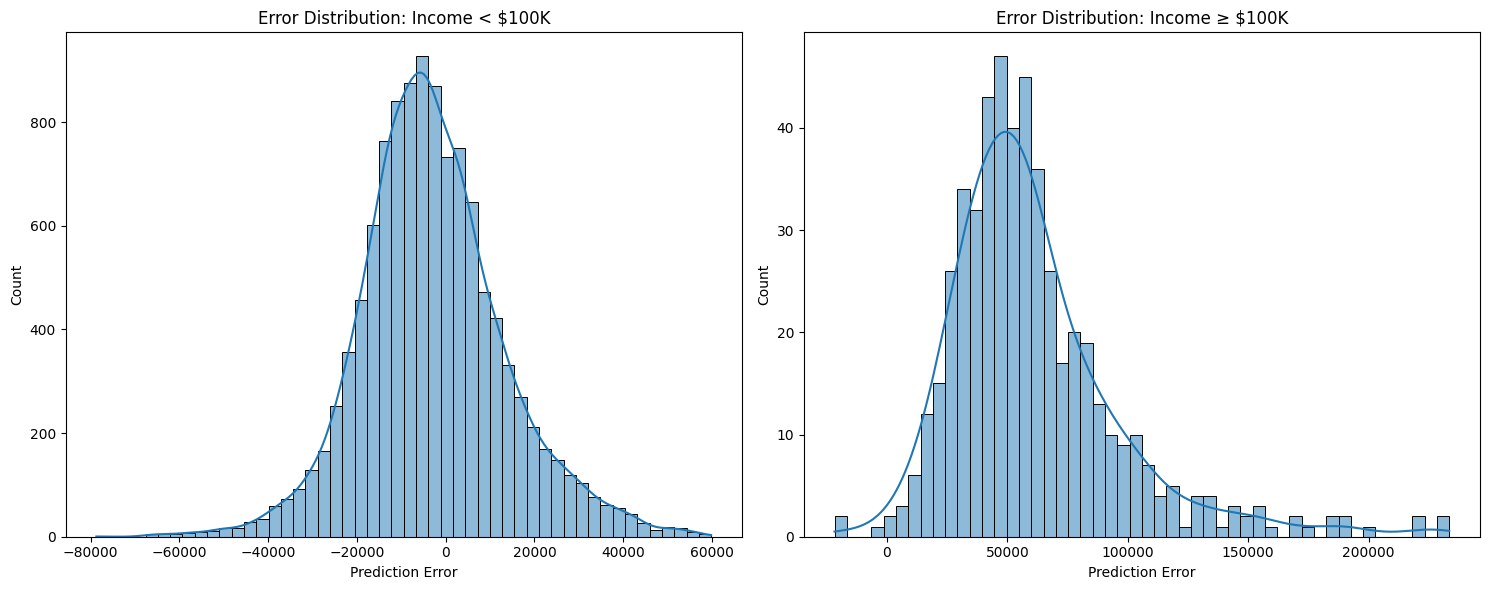

In [ ]:

mask_under_100k = y_true < 100000
mask_over_100k = y_true >= 100000

y_true_under = y_true[mask_under_100k]
y_pred_under = y_pred[mask_under_100k]

y_true_over = y_true[mask_over_100k]
y_pred_over = y_pred[mask_over_100k]

def print_metrics(y_true, y_pred, group_name):
    metrics = calculate_metrics(y_true, y_pred)
    income_metrics = income_specific_metrics(y_true, y_pred)
    
    print(f"\nMetrics for {group_name}:")
    print("Standard Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("\nIncome-Specific Metrics:")
    for k, v in income_metrics.items():
        print(f"{k}: {v:.2f}%")

#metrics for both groups
print_metrics(y_true_under, y_pred_under, "Income < $100K")
print_metrics(y_true_over, y_pred_over, "Income ≥ $100K")

def plot_comparison(y_true_under, y_pred_under, y_true_over, y_pred_over):
    plt.figure(figsize=(15, 6))
    
    # Under 100K
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true_under, y=y_pred_under, alpha=0.3)
    plt.plot([y_true_under.min(), y_true_under.max()], 
             [y_true_under.min(), y_true_under.max()], 'r--')
    plt.title('Income < $100K')
    plt.xlabel('Actual Income')
    plt.ylabel('Predicted Income')
    
    # Over 100K
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true_over, y=y_pred_over, alpha=0.3)
    plt.plot([y_true_over.min(), y_true_over.max()], 
             [y_true_over.min(), y_true_over.max()], 'r--')
    plt.title('Income ≥ $100K')
    plt.xlabel('Actual Income')
    plt.ylabel('Predicted Income')
    
    plt.tight_layout()
    plt.show()

#plot_comparison(y_true_under, y_pred_under, y_true_over, y_pred_over)

def plot_error_distributions(y_true_under, y_pred_under, y_true_over, y_pred_over):
    plt.figure(figsize=(15, 6))
    
    # Under 100K errors
    plt.subplot(1, 2, 1)
    errors_under = y_true_under - y_pred_under
    sns.histplot(errors_under, bins=50, kde=True)
    plt.title('Error Distribution: Income < $100K')
    plt.xlabel('Prediction Error')
    
    # Over 100K errors
    plt.subplot(1, 2, 2)
    errors_over = y_true_over - y_pred_over
    sns.histplot(errors_over, bins=50, kde=True)
    plt.title('Error Distribution: Income ≥ $100K')
    plt.xlabel('Prediction Error')
    
    plt.tight_layout()
    plt.show()

plot_error_distributions(y_true_under, y_pred_under, y_true_over, y_pred_over)



Missing values in EDUC: 0
Missing values in Actual: 0
Missing values in Predicted: 0


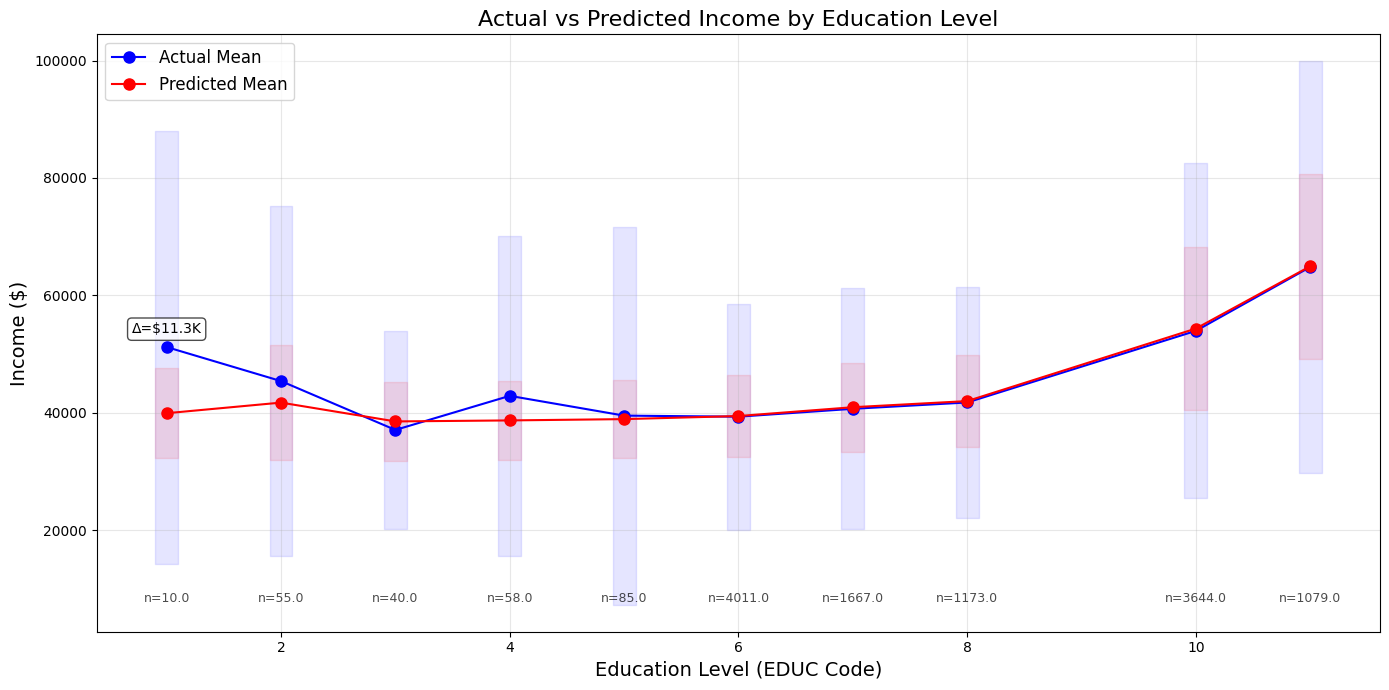


Education Levels with Largest Discrepancies:
   EDUC   Actual_Mean  Actual_Median  Sample_Count  Predicted_Mean  \
0   1.0  51185.800781        38878.0            10    39911.730469   
3   4.0  42869.707031        30000.0            58    38682.992188   
1   2.0  45385.074219        37142.0            55    41718.257812   
2   3.0  37061.800781        32307.0            40    38510.617188   
4   5.0  39500.695312        30677.0            85    38904.632812   

   Predicted_Median          Diff      Abs_Diff  
0      37677.447266  11274.070312  11274.070312  
3      37926.417969   4186.714844   4186.714844  
1      38976.289062   3666.816406   3666.816406  
2      38727.078125  -1448.816406   1448.816406  
4      37373.285156    596.062500    596.062500  


In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for *cat_inputs, x_num, y in test_loader:
        preds = model([*cat_inputs, x_num])
        y_true.append(y.numpy())
        y_pred.append(preds.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

#  First ensure all arrays have the same length
assert len(y_true) == len(y_pred) == len(X_test), "Array length mismatch - check your test set"

# Get EDUC values from test set (ensure we use the same samples)
educ_test = X_test['EDUC'].values[:len(y_true)]  # Safely truncate if needed

# Create DataFrame with aligned data
results = pd.DataFrame({
    'EDUC': educ_test,
    'Actual': y_true,
    'Predicted': y_pred
})

print(f"Missing values in EDUC: {results['EDUC'].isnull().sum()}")
print(f"Missing values in Actual: {results['Actual'].isnull().sum()}")
print(f"Missing values in Predicted: {results['Predicted'].isnull().sum()}")

results = results.dropna()

educ_stats = results.groupby('EDUC').agg({
    'Actual': ['mean', 'median', 'count'],
    'Predicted': ['mean', 'median']
}).reset_index()

# Flatten multi-index columns
educ_stats.columns = [
    'EDUC', 'Actual_Mean', 'Actual_Median', 'Sample_Count',
    'Predicted_Mean', 'Predicted_Median'
]

# Plotting
plt.figure(figsize=(14, 7))

# Plot mean lines with error bands
plt.plot(educ_stats['EDUC'], educ_stats['Actual_Mean'], 
         'o-', color='blue', label='Actual Mean', markersize=8)
plt.plot(educ_stats['EDUC'], educ_stats['Predicted_Mean'], 
         'o-', color='red', label='Predicted Mean', markersize=8)

# Add error bands showing ±1 standard deviation
for educ in educ_stats['EDUC']:
    subset = results[results['EDUC'] == educ]
    actual_std = subset['Actual'].std()
    pred_std = subset['Predicted'].std()
    plt.fill_between([educ-0.1, educ+0.1], 
                     [subset['Actual'].mean()-actual_std, subset['Actual'].mean()-actual_std],
                     [subset['Actual'].mean()+actual_std, subset['Actual'].mean()+actual_std],
                     color='blue', alpha=0.1)
    plt.fill_between([educ-0.1, educ+0.1], 
                     [subset['Predicted'].mean()-pred_std, subset['Predicted'].mean()-pred_std],
                     [subset['Predicted'].mean()+pred_std, subset['Predicted'].mean()+pred_std],
                     color='red', alpha=0.1)

# Formatting
plt.title('Actual vs Predicted Income by Education Level', fontsize=16)
plt.xlabel('Education Level (EDUC Code)', fontsize=14)
plt.ylabel('Income ($)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

# Annotate important discrepancies
for _, row in educ_stats.iterrows():
    delta = row['Actual_Mean'] - row['Predicted_Mean']
    if abs(delta) > 10000:  # Highlight large discrepancies
        plt.annotate(f'Δ=${delta/1000:.1f}K', 
                    (row['EDUC'], max(row['Actual_Mean'], row['Predicted_Mean'])),
                    textcoords="offset points", xytext=(0,10), ha='center',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
    # Show sample size
    plt.annotate(f'n={row["Sample_Count"]}', 
                (row['EDUC'], plt.ylim()[0] + 0.05*(plt.ylim()[1]-plt.ylim()[0])),
                ha='center', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

# Print education levels with largest discrepancies
print("\nEducation Levels with Largest Discrepancies:")
discrepancies = educ_stats.copy()
discrepancies['Diff'] = discrepancies['Actual_Mean'] - discrepancies['Predicted_Mean']
discrepancies['Abs_Diff'] = abs(discrepancies['Diff'])
print(discrepancies.sort_values('Abs_Diff', ascending=False).head(5))

## SHAP

C:\Users\Baban\AppData\Local\Temp\ipykernel_21284\1241243998.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, flat_input.numpy(), feature_names=feature_names)


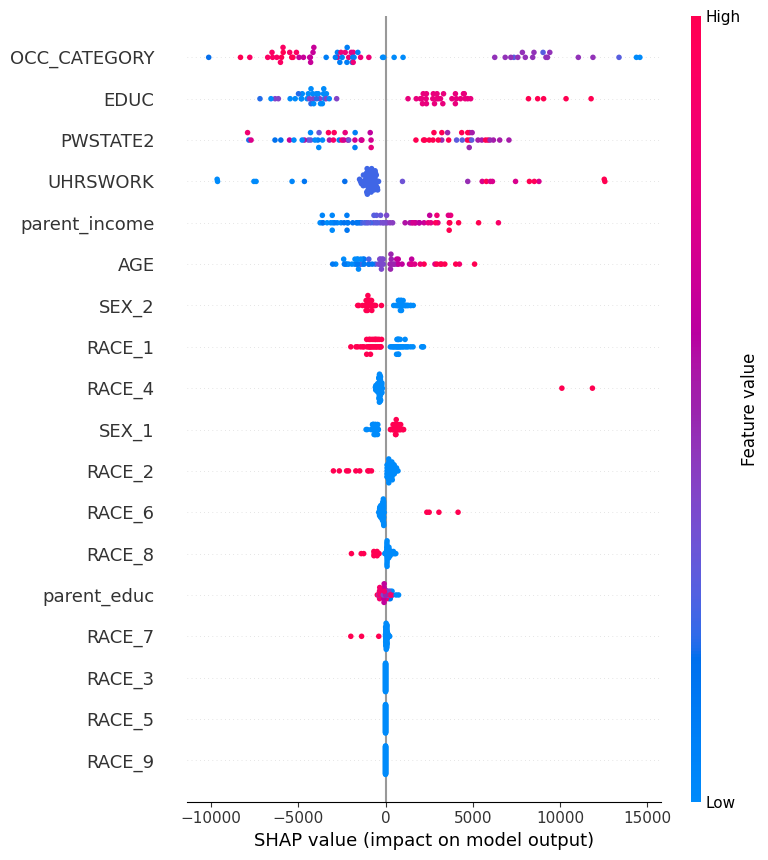

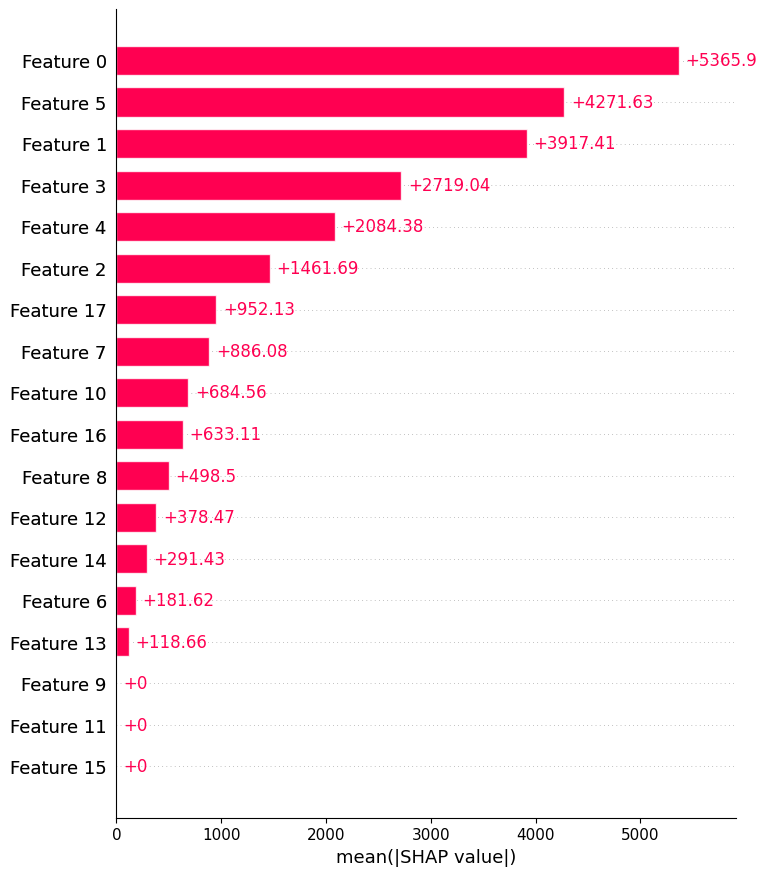

In [ ]:
# Fetch a batch of data from the test_loader
batch = next(iter(test_loader))  # Retrieve a batch from the test loader
cat_inputs = batch[:-2]   # all categorical inputs
x_num = batch[-2]         # numerical features
y_true = batch[-1]        # target variable

# Flatten the input (categorical + numerical)
flat_input = torch.cat([x.unsqueeze(1).float() for x in cat_inputs] + [x_num], dim=1)

# Define categorical and numerical feature dimensions
cat_dims = [1] * len(cat_inputs)  # each categorical feature is a single column
num_dims = [x_num.shape[1]]      # numerical features shape
split_sizes = cat_dims + num_dims

# Model wrapper for SHAP
def model_wrapper(input_array):
    tensors = torch.tensor(input_array, dtype=torch.float32)
    splits = torch.split(tensors, split_sizes, dim=1)

    # Splitting the input into categorical and numerical
    cat_tensors = [split.long().squeeze(1) for split in splits[:-1]]
    x_num_tensor = splits[-1]

    model.eval()
    with torch.no_grad():
        output = model(cat_tensors + [x_num_tensor])
    return output.numpy()

# Explaining the model
explainer = shap.Explainer(model_wrapper, flat_input.numpy())
shap_values = explainer(flat_input.numpy())

feature_names = embed_cols + numerical_cols

shap.summary_plot(shap_values.values, flat_input.numpy(), feature_names=feature_names)

# SHAP bar plot for feature importance with more features
shap.plots.bar(shap_values, max_display=30)  # Show the top 30 most important features

In [332]:
feature_names = embed_cols + numerical_cols

for n in range(0, len(feature_names)):
    print(f"Feature {n}: {feature_names[n]}")

Feature 0: OCC_CATEGORY
Feature 1: PWSTATE2
Feature 2: AGE
Feature 3: UHRSWORK
Feature 4: parent_income
Feature 5: EDUC
Feature 6: parent_educ
Feature 7: RACE_1
Feature 8: RACE_2
Feature 9: RACE_3
Feature 10: RACE_4
Feature 11: RACE_5
Feature 12: RACE_6
Feature 13: RACE_7
Feature 14: RACE_8
Feature 15: RACE_9
Feature 16: SEX_1
Feature 17: SEX_2


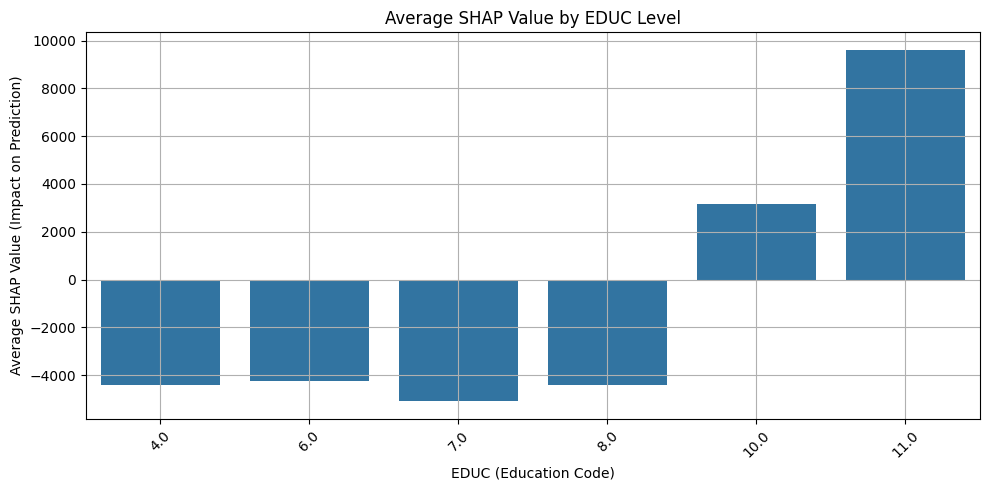

In [333]:
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
input_df = pd.DataFrame(flat_input.numpy(), columns=feature_names)

educ_vals = input_df['EDUC']
educ_shap = shap_df['EDUC']

grouped = pd.DataFrame({
    'EDUC': educ_vals,
    'EDUC_SHAP': educ_shap
}).groupby('EDUC').mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='EDUC', y='EDUC_SHAP', data=grouped)
plt.title("Average SHAP Value by EDUC Level")
plt.xlabel("EDUC (Education Code)")
plt.ylabel("Average SHAP Value (Impact on Prediction)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Baban\AppData\Local\Temp\ipykernel_21284\3280627203.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

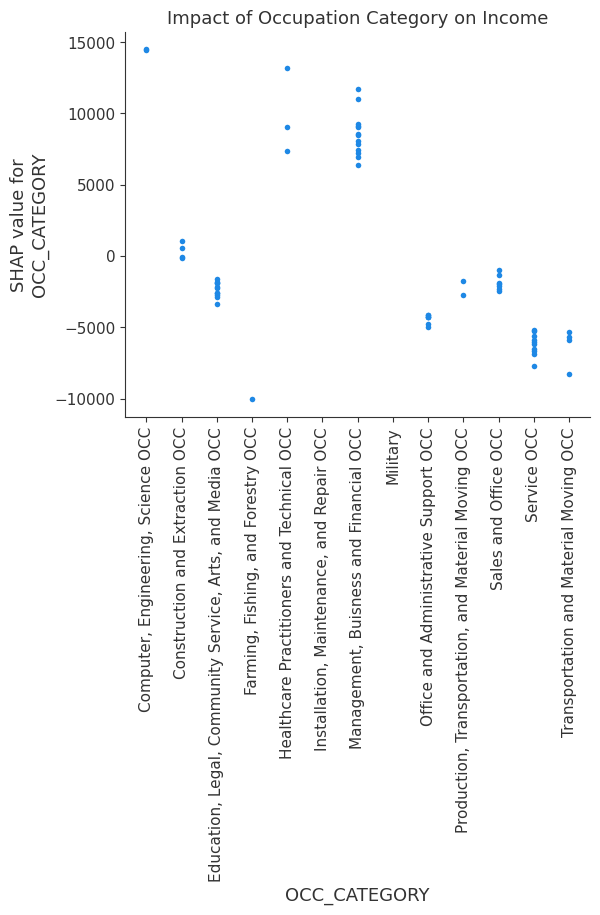

<Figure size 1200x1500 with 0 Axes>

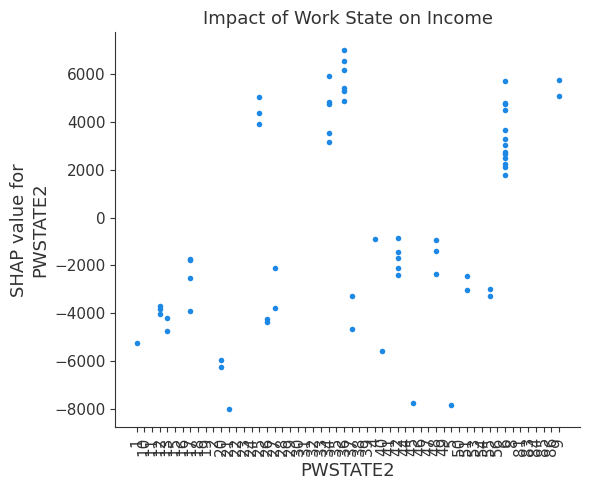

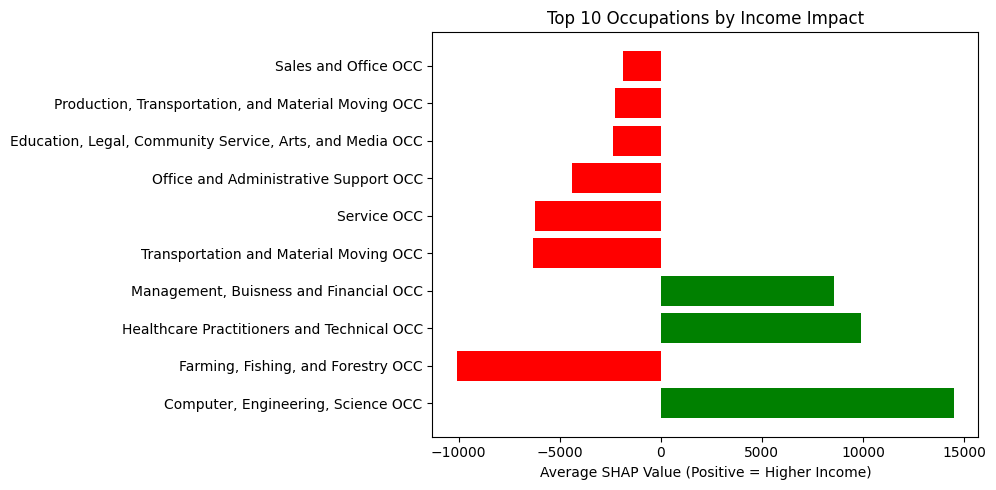

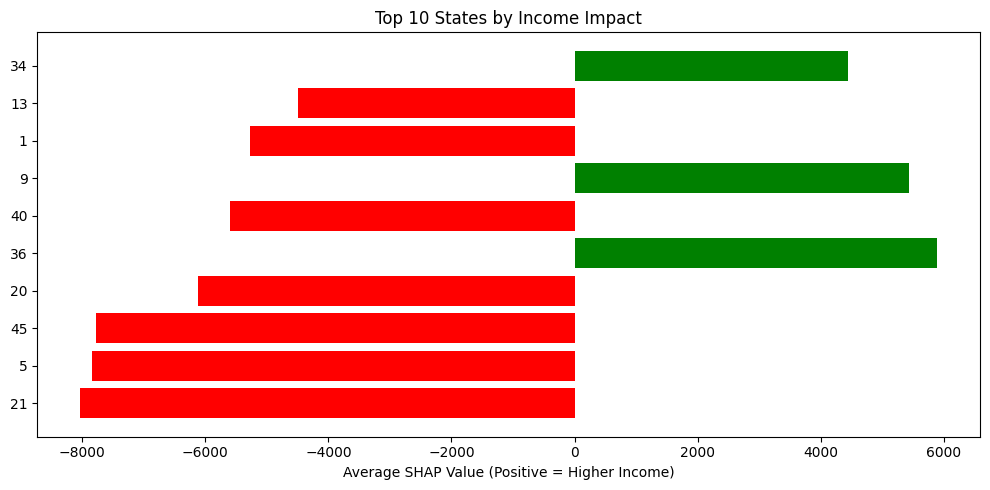

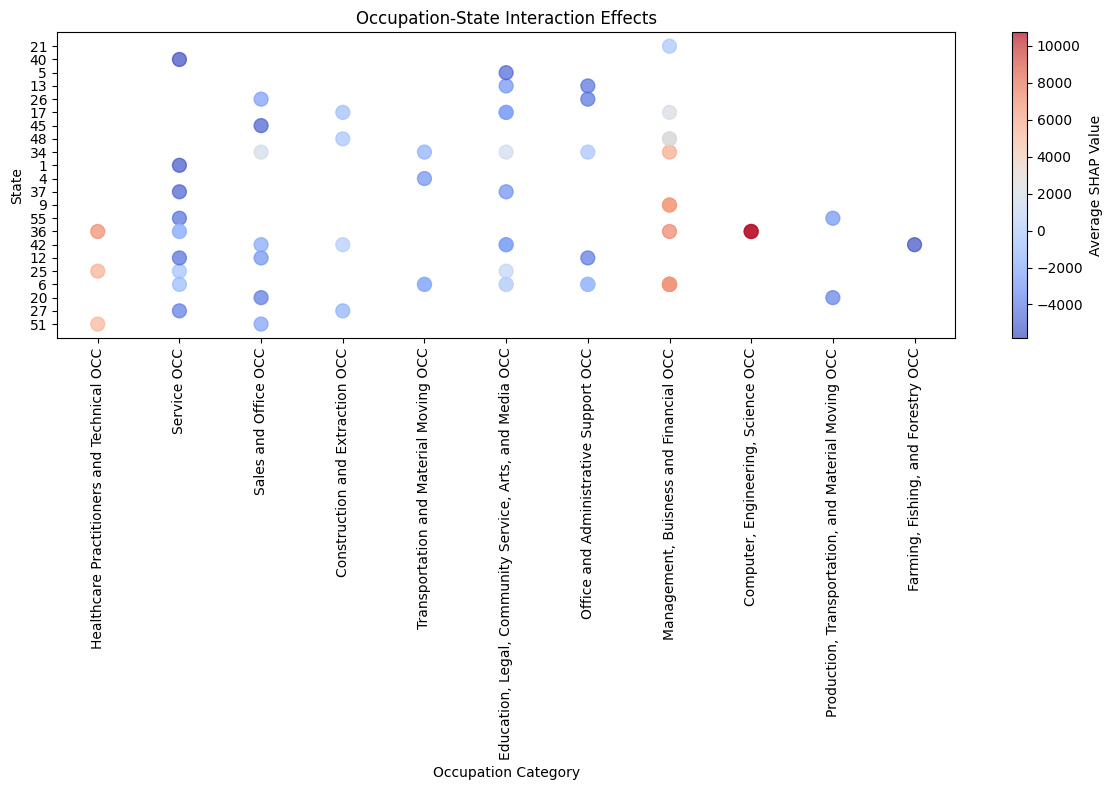

In [ ]:
# Fetch a batch of data from the test_loader
batch = next(iter(test_loader))  # Retrieve a batch from the test loader
cat_inputs = batch[:-2]   # all categorical inputs
x_num = batch[-2]         # numerical features
y_true = batch[-1]        # target variable

# Get the indices of our features of interest
occ_idx = embed_cols.index('OCC_CATEGORY')
state_idx = embed_cols.index('PWSTATE2')

# Convert categorical indices back to original labels
occ_labels = label_encoders['OCC_CATEGORY'].inverse_transform(cat_inputs[occ_idx].numpy())
state_labels = label_encoders['PWSTATE2'].inverse_transform(cat_inputs[state_idx].numpy())

# Flatten the input (categorical + numerical)
flat_input = torch.cat([x.unsqueeze(1).float() for x in cat_inputs] + [x_num], dim=1)

# Define categorical and numerical feature dimensions
cat_dims = [1] * len(cat_inputs)  # each categorical feature is a single column
num_dims = [x_num.shape[1]]      # numerical features shape
split_sizes = cat_dims + num_dims

# Model wrapper for SHAP
def model_wrapper(input_array):
    tensors = torch.tensor(input_array, dtype=torch.float32)
    splits = torch.split(tensors, split_sizes, dim=1)

    # Splitting the input into categorical and numerical
    cat_tensors = [split.long().squeeze(1) for split in splits[:-1]]
    x_num_tensor = splits[-1]

    model.eval()
    with torch.no_grad():
        output = model(cat_tensors + [x_num_tensor])
    return output.numpy()


explainer = shap.Explainer(model_wrapper, flat_input.numpy())
shap_values = explainer(flat_input.numpy())

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    embed_cols.index('OCC_CATEGORY'),
    shap_values.values,
    flat_input.numpy(),
    feature_names=embed_cols + numerical_cols,
    interaction_index=None,
    title="Impact of Occupation Category on Income",
    show=False
)
plt.gca().set_xticks(range(len(label_encoders['OCC_CATEGORY'].classes_)))
plt.gca().set_xticklabels(label_encoders['OCC_CATEGORY'].classes_, rotation=90)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 15))
shap.dependence_plot(
    embed_cols.index('PWSTATE2'),
    shap_values.values,
    flat_input.numpy(),
    feature_names=embed_cols + numerical_cols,
    interaction_index=None,
    title="Impact of Work State on Income",
    show=False
)
plt.gca().set_xticks(range(len(label_encoders['PWSTATE2'].classes_)))
plt.gca().set_xticklabels(label_encoders['PWSTATE2'].classes_, rotation=90)
plt.tight_layout()
plt.show()


occ_shap = shap_values.values[:, embed_cols.index('OCC_CATEGORY')]
occ_impact = {occ: np.mean(occ_shap[occ_labels == occ]) for occ in np.unique(occ_labels)}
top_occ = sorted(occ_impact.items(), key=lambda x: -abs(x[1]))[:10]

plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in top_occ], [x[1] for x in top_occ],
         color=['red' if x[1] < 0 else 'green' for x in top_occ])
plt.title("Top 10 Occupations by Income Impact")
plt.xlabel("Average SHAP Value (Positive = Higher Income)")
plt.tight_layout()
plt.show()


state_shap = shap_values.values[:, embed_cols.index('PWSTATE2')]
state_impact = {state: np.mean(state_shap[state_labels == state]) for state in np.unique(state_labels)}
top_states = sorted(state_impact.items(), key=lambda x: -abs(x[1]))[:10]

plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in top_states], [x[1] for x in top_states],
         color=['red' if x[1] < 0 else 'green' for x in top_states])
plt.title("Top 10 States by Income Impact")
plt.xlabel("Average SHAP Value (Positive = Higher Income)")
plt.tight_layout()
plt.show()

# 5. Occupation-State Interaction
interaction_shap = shap_values.values[:, [embed_cols.index('OCC_CATEGORY'), embed_cols.index('PWSTATE2')]]
plt.figure(figsize=(12, 8))
plt.scatter(occ_labels, state_labels, 
            c=interaction_shap.mean(axis=1), 
            cmap='coolwarm', 
            s=100, 
            alpha=0.7)
plt.colorbar(label='Average SHAP Value')
plt.title("Occupation-State Interaction Effects")
plt.xlabel("Occupation Category")
plt.ylabel("State")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Extras

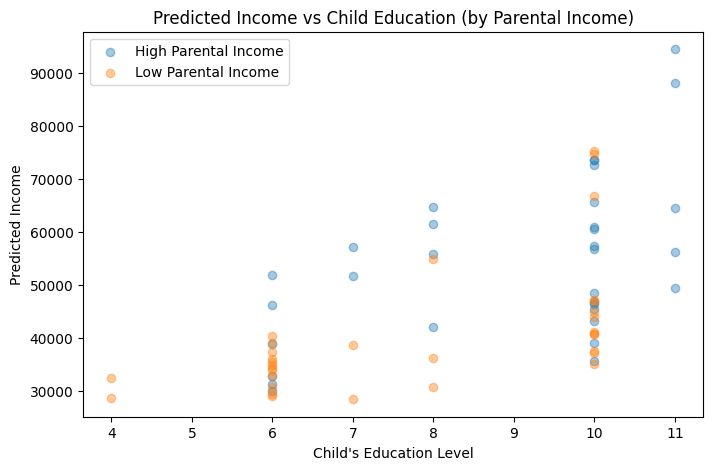

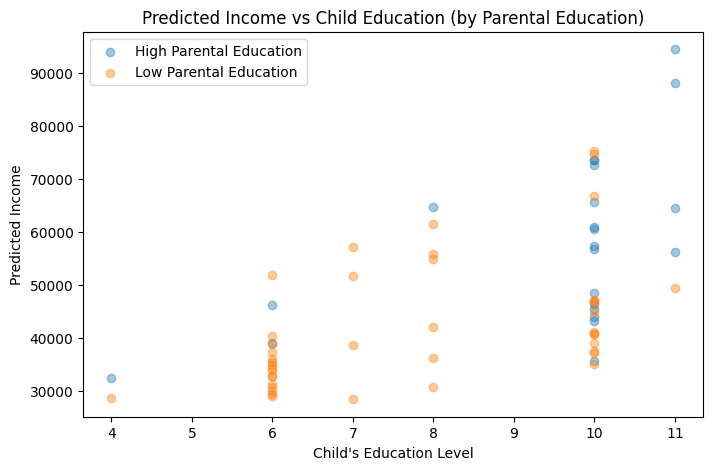

In [ ]:
# Define thresholds to split low/high groups (e.g., median)
parent_income_col = feature_names.index("parent_income")
parent_edu_col = feature_names.index("parent_educ")
child_edu_col = feature_names.index("EDUC")

X = flat_input.numpy()

# Split groups
median_income = np.median(X[:, parent_income_col])
median_edu = np.median(X[:, parent_edu_col])

def get_preds_by_group(x, condition_col, condition_val, child_edu_col):
    # Select subgroup
    mask = x[:, condition_col] > condition_val
    high_group = x[mask]
    low_group = x[~mask]

    # Get predictions
    def predict(arr):
        tensors = torch.tensor(arr, dtype=torch.float32)
        splits = torch.split(tensors, split_sizes, dim=1)
        cat_tensors = [split.long().squeeze(1) for split in splits[:-1]]
        x_num_tensor = splits[-1]
        model.eval()
        with torch.no_grad():
            return model(cat_tensors + [x_num_tensor]).numpy().flatten()

    return (
        high_group[:, child_edu_col], predict(high_group),
        low_group[:, child_edu_col], predict(low_group)
    )

# 1. By Parental Income
child_edu_high_inc, y_pred_high_inc, child_edu_low_inc, y_pred_low_inc = get_preds_by_group(
    X, parent_income_col, median_income, child_edu_col
)

plt.figure(figsize=(8,5))
plt.scatter(child_edu_high_inc, y_pred_high_inc, alpha=0.4, label="High Parental Income")
plt.scatter(child_edu_low_inc, y_pred_low_inc, alpha=0.4, label="Low Parental Income")
plt.xlabel("Child's Education Level")
plt.ylabel("Predicted Income")
plt.title("Predicted Income vs Child Education (by Parental Income)")
plt.legend()
plt.show()

# 2. By Parental Education
child_edu_high_edu, y_pred_high_edu, child_edu_low_edu, y_pred_low_edu = get_preds_by_group(
    X, parent_edu_col, median_edu, child_edu_col
)

plt.figure(figsize=(8,5))
plt.scatter(child_edu_high_edu, y_pred_high_edu, alpha=0.4, label="High Parental Education")
plt.scatter(child_edu_low_edu, y_pred_low_edu, alpha=0.4, label="Low Parental Education")
plt.xlabel("Child's Education Level")
plt.ylabel("Predicted Income")
plt.title("Predicted Income vs Child Education (by Parental Education)")
plt.legend()
plt.show()



In [ ]:
# # Choose immutable feature columns
# race_idx = feature_names.index("RACE")
# sex_idx = feature_names.index("SEX")
# pedu_idx = feature_names.index("parent_educ")

# # Select a few individuals for demonstration (or loop over full set)
# X = flat_input.numpy()
# X_orig = X[:100]  # 100 individuals for example

# # Define a helper to simulate counterfactuals
# def predict_income(x_array):
#     tensors = torch.tensor(x_array, dtype=torch.float32)
#     splits = torch.split(tensors, split_sizes, dim=1)
#     cat_tensors = [split.long().squeeze(1) for split in splits[:-1]]
#     x_num_tensor = splits[-1]
#     model.eval()
#     with torch.no_grad():
#         return model(cat_tensors + [x_num_tensor]).numpy().flatten()

# # Function to run counterfactual simulation
# def counterfactual_effect(X_base, feature_idx, new_value):
#     X_cf = copy.deepcopy(X_base)
#     X_cf[:, feature_idx] = new_value
#     y_orig = predict_income(X_base)
#     y_cf = predict_income(X_cf)
#     delta = y_cf - y_orig
#     return delta

# # Simulate changing race to a fixed value (e.g., 0 = reference group)
# delta_race = counterfactual_effect(X_orig, race_idx, new_value=0)

# # Simulate changing parental education to high (e.g., top-coded)
# high_pedu_value = np.percentile(X[:, pedu_idx], 90)
# delta_pedu = counterfactual_effect(X_orig, pedu_idx, new_value=high_pedu_value)

# plt.figure(figsize=(8,4))
# plt.hist(delta_race, bins=30, alpha=0.7, label="Change in predicted income if race = 0")
# plt.xlabel("Predicted Income Change")
# plt.title("Counterfactual Impact of Race")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,4))
# plt.hist(delta_pedu, bins=30, alpha=0.7, label="Change if parental education = high")
# plt.xlabel("Predicted Income Change")
# plt.title("Counterfactual Impact of Parental Education")
# plt.legend()
# plt.show()


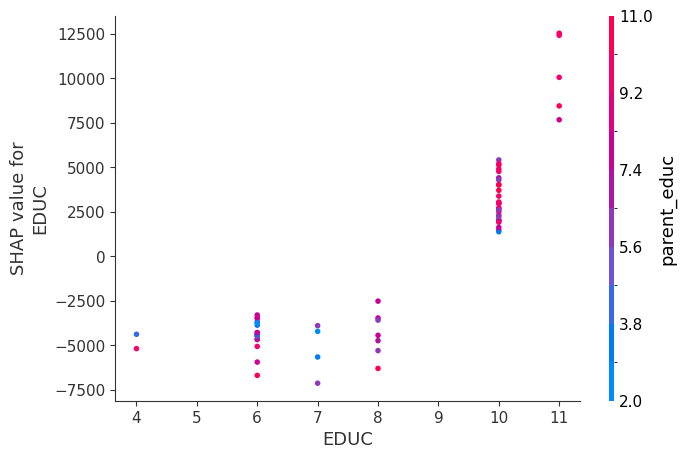

In [ ]:
shap.dependence_plot(
    ind='EDUC',  # Child education
    shap_values=shap_values.values,
    features=flat_input.numpy(),
    feature_names=embed_cols + numerical_cols,
    interaction_index='parent_educ'  # Interaction with parental education
)

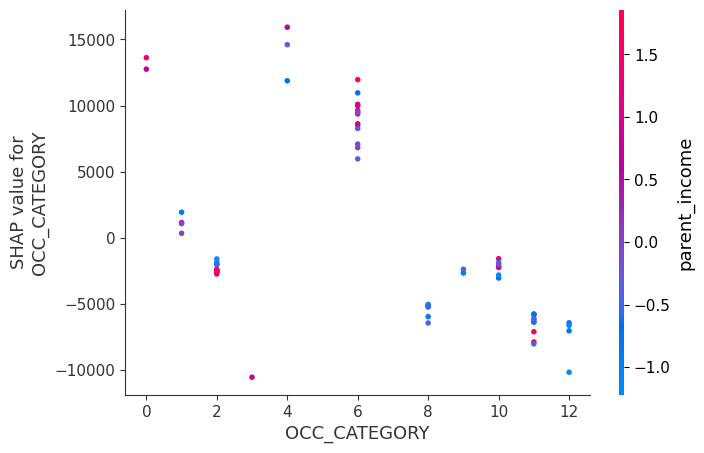

In [ ]:
shap.dependence_plot(
    'OCC_CATEGORY', shap_values.values, flat_input.numpy(),
    feature_names=feature_names, interaction_index='parent_income'
)